In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from scipy import stats
# from scipy.interpolate import \
#     interp2d, griddata, RegularGridInterpolator, RectBivariateSpline, \
#     NearestNDInterpolator, LinearNDInterpolator

from vivarium import Artifact # This is causing my kernel to die!!! Memory leak?
import gbd_mapping as gbd
from db_queries import get_ids
from get_draws.api import get_draws

from vivarium_helpers.id_helper import *

# Add path to vivarium_research_lsff to sys.path so imports will work from sibling folders
import sys, os.path
# Note: Assuming pwd = vivarium_research_lsff/nanosim_models
vivarium_research_lsff_path = os.path.abspath("..")
print(vivarium_research_lsff_path)
sys.path.append(vivarium_research_lsff_path)

import lbwsg
import lbwsg_boe # Requires path to vivarium_research_lsff to be in sys.path
import data_processing # Requires path to vivarium_research_lsff to be in sys.path
import lsff_interventions
import demography
import test_lbwsg
import lbwsg_plots
import functions_for_all_nutrients as ffan


# Assumes the path to vivarium_research_lsff is in sys.path
from gbd_data_summary import pull_gbd2019_data as pgd, rank_countries_by_stunting as rbs

!date
!whoami

/ihme/homes/ndbs/vivarium_research_lsff
Mon Apr 12 13:08:14 PDT 2021
ndbs


In [2]:
locations = pd.read_csv('../gbd_data_summary/input_data/bmgf_top_25_countries_20201203.csv')
location_ids = locations.location_id.to_list()
locations

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_name,location_id
0,Angola,168
1,Bangladesh,161
2,Burkina Faso,201
3,Cameroon,202
4,China,6
5,Côte d'Ivoire,205
6,Democratic Republic of the Congo,171
7,Egypt,141
8,Ethiopia,179
9,Ghana,207


In [9]:
input_data = data_processing.get_fortification_input_data()
input_data._fields

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('locations', 'coverage', 'consumption', 'concentration')

In [14]:
hdfstore = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
daly_key = '/gbd_2019/burden/dalys/bmgf_25_countries_all_causes_u5'
lbwsg_dalys = pd.read_hdf(hdfstore, daly_key)
print(lbwsg_dalys.shape)
lbwsg_dalys.head()

(400, 1008)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age_group_id,cause_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_996,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,rei_id,sex_id,year_id
0,2,294,1.686419e+06,1.380130e+06,1.532356e+06,1.881991e+06,1.788590e+06,1.495778e+06,1.445608e+06,1.678928e+06,...,1.921181e+06,1.627784e+06,1.576942e+06,1.527543e+06,11,2,1,339,1,2019
1,3,294,2.372134e+05,1.919278e+05,2.170731e+05,2.544907e+05,2.529692e+05,2.068530e+05,2.069783e+05,2.373931e+05,...,2.929817e+05,2.268086e+05,2.274535e+05,2.251821e+05,11,2,1,339,1,2019
2,4,294,1.031197e+04,1.175409e+04,1.310527e+04,2.029776e+04,1.402736e+04,1.540469e+04,1.218204e+04,1.223268e+04,...,1.545804e+04,1.430644e+04,1.593838e+04,1.818412e+04,11,2,1,339,1,2019
3,5,294,1.314011e+04,1.049391e+04,9.882648e+03,1.343891e+04,1.060694e+04,8.110735e+03,8.740023e+03,9.319688e+03,...,8.134459e+03,1.056513e+04,9.261209e+03,9.793473e+03,11,2,1,339,1,2019
4,2,294,1.006098e+06,8.333760e+05,9.432532e+05,1.105773e+06,1.164879e+06,9.078354e+05,8.866824e+05,1.011378e+06,...,1.193013e+06,1.001989e+06,9.913213e+05,9.189253e+05,11,2,1,339,2,2019


In [5]:
raw_results = pd.read_csv('results/iron_bw_results.csv')
print(raw_results.shape)
raw_results.head()

(378, 254)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coverage_level,location_id,measure,vehicle,draw_4,draw_6,draw_10,draw_13,draw_16,draw_18,...,draw_971,draw_973,draw_974,draw_978,draw_981,draw_985,draw_988,draw_992,draw_994,draw_999
0,0.2,6,counts_averted,wheat flour,2904.543372,3749.252406,5431.758587,4862.595241,6909.634628,917.572898,...,3247.119810,2945.899057,3093.888739,4450.653495,3373.314205,3980.202743,1443.065174,2202.609063,1817.149521,3654.702138
1,0.2,11,counts_averted,wheat flour,0.410664,55.025127,205.150746,4.903218,147.438639,166.470581,...,130.557224,99.136743,43.440180,55.307435,68.835866,36.359475,130.843194,318.490189,87.106196,30.681769
2,0.2,15,counts_averted,wheat flour,22.630438,39.480737,83.344657,17.356558,85.796009,25.949345,...,32.987038,51.778511,36.298628,75.879004,24.705208,29.401829,44.477208,51.528323,10.900119,84.762431
3,0.2,20,counts_averted,wheat flour,40.655603,36.804245,51.674548,65.486548,63.615450,3.636705,...,51.911889,18.471326,69.239954,98.195414,33.785295,13.679045,21.388484,30.470178,24.439117,36.171505
4,0.2,141,counts_averted,maize flour,366.596716,698.946383,2010.007523,146.087604,643.183569,472.132097,...,292.371701,470.511168,1017.240468,1083.183300,892.482109,384.333877,923.678018,458.504144,454.108400,385.494035


In [8]:
raw_results.query("coverage_level==0.8 and measure=='counts_averted'").shape

(42, 254)

In [12]:
results = locations.merge(raw_results)
results.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_name,location_id,coverage_level,measure,vehicle,draw_4,draw_6,draw_10,draw_13,draw_16,...,draw_971,draw_973,draw_974,draw_978,draw_981,draw_985,draw_988,draw_992,draw_994,draw_999
0,Angola,168,0.2,counts_averted,maize flour,116.942173,471.418704,1333.554944,26.696682,419.201567,...,54.887772,71.464280,94.413106,178.530620,268.516617,70.119366,314.463709,233.058271,30.424647,151.873750
1,Angola,168,0.2,counts_averted,wheat flour,544.029093,588.303588,484.540065,141.337924,1000.981797,...,328.629359,145.518986,576.876996,383.339021,467.115461,375.468441,72.188444,572.533315,360.220510,352.265379
2,Angola,168,0.5,counts_averted,maize flour,151.328654,581.270734,1706.038170,34.686640,551.181150,...,67.374830,98.642023,129.763371,237.220811,352.352137,84.401957,387.578124,281.538556,36.143190,198.387438
3,Angola,168,0.5,counts_averted,wheat flour,664.119992,715.037533,637.666508,179.538419,1227.197755,...,418.081555,182.574311,761.663681,472.465730,571.925262,488.946001,90.626736,744.660196,472.723186,410.268762
4,Angola,168,0.8,counts_averted,maize flour,169.896261,687.138638,1980.984399,41.282671,641.837602,...,79.939365,113.068212,151.051533,288.832425,433.448222,103.595260,449.309343,340.189881,39.248849,233.205811


In [28]:
for measure in results.measure.unique():
    print(results.query("measure==@measure").shape)

(126, 255)
(126, 255)
(126, 255)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
def describe_draws(data):
    draw_cols = data.filter(like='draw').columns.to_list()
    index_cols = data.columns.difference(draw_cols).to_list()
    described = (
        data.set_index(index_cols)
        .T.describe(percentiles=[0.025, 0.975]).T
    )
    return described

def get_wide_results_summary(results):
    results = describe_draws(results)[['mean', '2.5%', '97.5%']]
    dalys = results.xs('counts_averted', level='measure')
    pifs  = results.xs('pif', level='measure')
    rates = results.xs('rates_averted', level='measure')
    return pd.concat([dalys, pifs, rates], keys=['counts_averted', 'pif', 'rates_averted'], axis=1)

def aggregate_over_age_and_sex(data):
    """for age groups 2 and 3."""
    draw_cols = data.filter(like='draw').columns.to_list()
    agg_data = (
        data
        .query('age_group_id in [2,3] and metric_id==1')
        .groupby('location_id')[draw_cols]
        .sum() # Aggregate over age_group and sex
    )
    return agg_data

def get_coverage_summary(coverage_df):
    coverage_df = coverage_df.query("location_id==@location_id and vehicle==@vehicle and wra_applicable==True")
    fortified = coverage_df.query("nutrient=='iron' and value_description == 'percent of population eating fortified vehicle'")
    fortifiable = coverage_df.query("value_description == 'percent of population eating industrially produced vehicle'")
    assert len(fortified)==1 and len(fortifiable)==1

In [65]:
get_wide_results_summary(raw_results)

counts_averted                \
                                                 mean          2.5%   
coverage_level location_id vehicle                                    
0.2            6           wheat flour    4044.833032   1167.793475   
               11          wheat flour     221.899636      1.145456   
               15          wheat flour      49.661463      8.966243   
               20          wheat flour      47.258159     10.316207   
               141         maize flour     734.034587    149.021326   
...                                               ...           ...   
0.8            213         wheat flour     187.682173      5.706691   
               214         maize flour    7368.609916   2748.559125   
                           wheat flour   26232.641277  10399.039731   
               522         maize flour      75.081791     16.988313   
                           wheat flour    4832.712680   1645.622561   

                                                           pif            \
                                               97.5%      mean      2.5%   
coverage_level location_id vehicle                                         
0.2            6           wheat flour   8287.571804  0.134608  0.044118   
               11          wheat flour    842.360587  0.007553  0.000052   
               15          wheat flour    133.313935  0.003824  0.000691   
               20          wheat flour    110.038839  0.009726  0.002221   
               141         maize flour   2123.124731  0.119532  0.031201   
...                                              ...       ...       ...   
0.8            213         wheat flour    472.731834  0.008700  0.000270   
               214         maize flour  14131.431691  0.041404  0.017244   
                           wheat flour  45547.044321  0.147102  0.059221   
               522         maize flour    232.521392  0.004856  0.001137   
                           wheat flour  10927.116487  0.310553  0.110609   

                                                 rates_averted             \
                                           97.5%          mean       2.5%   
coverage_level location_id vehicle                                          
0.2            6           wheat flour  0.266867      5.021596   1.335072   
               11          wheat flour  0.027740      1.135596   0.006102   
               15          wheat flour  0.009991      0.988998   0.174746   
               20          wheat flour  0.020565      0.678775   0.150548   
               141         maize flour  0.359661      6.752802   1.273862   
...                                          ...           ...        ...   
0.8            213         wheat flour  0.021619      3.842004   0.107710   
               214         maize flour  0.078413     22.185035   7.915679   
                           wheat flour  0.245305     78.872530  30.653702   
               522         maize flour  0.015715      1.378988   0.296883   
                           wheat flour  0.652741     88.598204  30.416685   

                                                    
                                             97.5%  
coverage_level location_id vehicle                  
0.2            6           wheat flour   10.229509  
               11          wheat flour    4.376385  
               15          wheat flour    2.722083  
               20          wheat flour    1.609236  
               141         maize flour   19.818087  
...                                            ...  
0.8            213         wheat flour    9.737966  
               214         maize flour   44.266991  
                           wheat flour  139.320172  
               522         maize flour    4.239499  
                           wheat flour  206.155538  

[126 rows x 9 columns]

In [27]:
results_summary = describe_draws(results)
results_summary

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count  \
coverage_level location_id location_name measure        vehicle              
0.2            168         Angola        counts_averted maize flour  250.0   
                                                        wheat flour  250.0   
0.5            168         Angola        counts_averted maize flour  250.0   
                                                        wheat flour  250.0   
0.8            168         Angola        counts_averted maize flour  250.0   
...                                                                    ...   
0.5            20          Viet Nam      pif            wheat flour  250.0   
0.8            20          Viet Nam      pif            wheat flour  250.0   
0.2            20          Viet Nam      rates_averted  wheat flour  250.0   
0.5            20          Viet Nam      rates_averted  wheat flour  250.0   
0.8            20          Viet Nam      rates_averted  wheat flour  250.0   

                                                                           mean  \
coverage_level location_id location_name measure        vehicle                   
0.2            168         Angola        counts_averted maize flour  292.234309   
                                                        wheat flour  495.838833   
0.5            168         Angola        counts_averted maize flour  367.273760   
                                                        wheat flour  622.318747   
0.8            168         Angola        counts_averted maize flour  438.762022   
...                                                                         ...   
0.5            20          Viet Nam      pif            wheat flour    0.011940   
0.8            20          Viet Nam      pif            wheat flour    0.014172   
0.2            20          Viet Nam      rates_averted  wheat flour    0.678775   
0.5            20          Viet Nam      rates_averted  wheat flour    0.833521   
0.8            20          Viet Nam      rates_averted  wheat flour    0.989577   

                                                                            std  \
coverage_level location_id location_name measure        vehicle                   
0.2            168         Angola        counts_averted maize flour  271.107996   
                                                        wheat flour  386.435522   
0.5            168         Angola        counts_averted maize flour  340.810196   
                                                        wheat flour  484.275315   
0.8            168         Angola        counts_averted maize flour  403.579795   
...                                                                         ...   
0.5            20          Viet Nam      pif            wheat flour    0.005881   
0.8            20          Viet Nam      pif            wheat flour    0.007064   
0.2            20          Viet Nam      rates_averted  wheat flour    0.359154   
0.5            20          Viet Nam      rates_averted  wheat flour    0.443683   
0.8            20          Viet Nam      rates_averted  wheat flour    0.532700   

                                                                          min  \
coverage_level location_id location_name measure        vehicle                 
0.2            168         Angola        counts_averted maize flour  5.102164   
                                                        wheat flour  2.656899   
0.5            168         Angola        counts_averted maize flour  5.535338   
                                                        wheat flour  2.770196   
0.8            168         Angola        counts_averted maize flour  5.893641   
...                                                                       ...   
0.5            20          Viet Nam      pif            wheat flour  0.000743   
0.8            20          Viet Nam      pif            wheat flour  0.000974   
0.2            20          Viet Nam      rates_averted  wheat flour  0.043489   
0.5

In [18]:
describe_draws(lbwsg_dalys)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age_group_id,cause_id,location_id,measure_id,metric_id,rei_id,sex_id,year_id,,,,,,,,
2,294,11,2,1,339,1,2019,1000.0,1.569374e+06,199858.909881,1.021821e+06,1.210091e+06,1.560719e+06,1.988961e+06,2.337110e+06
3,294,11,2,1,339,1,2019,1000.0,2.277410e+05,31868.559205,1.521370e+05,1.677694e+05,2.271389e+05,2.930153e+05,3.454004e+05
4,294,11,2,1,339,1,2019,1000.0,1.466355e+04,3004.764680,8.064204e+03,9.687914e+03,1.433149e+04,2.141511e+04,2.863671e+04
5,294,11,2,1,339,1,2019,1000.0,1.058159e+04,1424.847953,6.344556e+03,8.009126e+03,1.045803e+04,1.357445e+04,1.578160e+04
2,294,11,2,1,339,2,2019,1000.0,9.744481e+05,121105.349471,6.648715e+05,7.581053e+05,9.675990e+05,1.222155e+06,1.542407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,294,6,2,2,339,1,2019,1000.0,1.940413e-02,0.002200,1.357097e-02,1.518723e-02,1.921530e-02,2.377785e-02,2.767973e-02
2,294,6,2,2,339,2,2019,1000.0,6.400835e-01,0.020341,5.411549e-01,5.976519e-01,6.417720e-01,6.739920e-01,6.943832e-01
3,294,6,2,2,339,2,2019,1000.0,4.590072e-01,0.018163,3.904553e-01,4.220610e-01,4.603737e-01,4.903342e-01,5.125376e-01


In [19]:
lbwsg_dalys.sex_id.unique()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1, 2])

In [24]:
attributable_dalys = describe_draws(aggregate_over_age_and_sex(lbwsg_dalys).reset_index())
attributable_dalys

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
6,1000.0,3.020323e+06,2.334930e+05,2.425483e+06,2.592632e+06,3.013043e+06,3.502776e+06,3.920967e+06
11,1000.0,2.906796e+06,3.645498e+05,1.975106e+06,2.259084e+06,2.893260e+06,3.654713e+06,4.433734e+06
15,1000.0,1.299311e+06,1.942679e+05,8.272960e+05,9.530097e+05,1.288705e+06,1.687772e+06,2.172640e+06
20,1000.0,4.967312e+05,7.779344e+04,3.062882e+05,3.612072e+05,4.922187e+05,6.695436e+05,8.198843e+05
141,1000.0,6.207430e+05,1.456755e+05,3.033847e+05,3.708534e+05,6.158229e+05,9.309389e+05,1.149037e+06
161,1000.0,3.596344e+06,4.831461e+05,2.275135e+06,2.703388e+06,3.571234e+06,4.606806e+06,5.137508e+06
163,1000.0,4.042671e+07,4.242136e+06,2.781975e+07,3.313180e+07,4.008132e+07,5.024715e+07,5.525268e+07
164,1000.0,7.701706e+05,7.923425e+04,5.537307e+05,6.252131e+05,7.662085e+05,9.366162e+05,1.051196e+06
165,1000.0,1.936298e+07,1.950510e+06,1.367498e+07,1.577360e+07,1.926436e+07,2.342991e+07,2.702426e+07


In [26]:
input_data.coverage

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
0,179,Ethiopia,NaN,maize flour,percent of population eating vehicle,na,59.263848,24.950317,93.577380,True,True
1,179,Ethiopia,NaN,maize flour,percent of population eating industrially prod...,na,27.167514,11.437632,42.897396,True,True
2,179,Ethiopia,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000020,0.000010,0.000030,True,True
3,179,Ethiopia,NaN,maize flour,percent of population eating fortified vehicle,iron,0.000020,0.000010,0.000030,True,True
4,179,Ethiopia,NaN,maize flour,percent of population eating fortified vehicle,vitamin a,0.000020,0.000010,0.000030,True,True
...,...,...,...,...,...,...,...,...,...,...,...
329,522,Sudan,NaN,wheat flour,percent of population eating industrially prod...,na,57.902255,28.488257,87.316254,True,True
330,522,Sudan,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,6.525113,3.210395,9.839831,True,True
331,522,Sudan,NaN,wheat flour,percent of population eating fortified vehicle,iron,6.525113,3.210395,9.839831,True,True
332,522,Sudan,NaN,wheat flour,percent of population eating fortified vehicle,vitamin a,6.525113,3.210395,9.839831,True,True


In [31]:
wheat_dalys_high = results_summary.query(
    "measure=='counts_averted' and vehicle=='wheat flour' and coverage_level==0.8")
print(wheat_dalys_high.shape)
wheat_dalys_high

(25, 8)


count  \
coverage_level location_id location_name                    measure        vehicle              
0.8            168         Angola                           counts_averted wheat flour  250.0   
               161         Bangladesh                       counts_averted wheat flour  250.0   
               201         Burkina Faso                     counts_averted wheat flour  250.0   
               202         Cameroon                         counts_averted wheat flour  250.0   
               6           China                            counts_averted wheat flour  250.0   
               205         Côte d'Ivoire                    counts_averted wheat flour  250.0   
               171         Democratic Republic of the Congo counts_averted wheat flour  250.0   
               141         Egypt                            counts_averted wheat flour  250.0   
               179         Ethiopia                         counts_averted wheat flour  250.0   
               207         Ghana                            counts_averted wheat flour  250.0   
               163         India                            counts_averted wheat flour  250.0   
               11          Indonesia                        counts_averted wheat flour  250.0   
               180         Kenya                            counts_averted wheat flour  250.0   
               181         Madagascar                       counts_averted wheat flour  250.0   
               184         Mozambique                       counts_averted wheat flour  250.0   
               15          Myanmar                          counts_averted wheat flour  250.0   
               164         Nepal                            counts_averted wheat flour  250.0   
               213         Niger                            counts_averted wheat flour  250.0   
               214         Nigeria                          counts_averted wheat flour  250.0   
               165         Pakistan                         counts_averted wheat flour  250.0   
               196         South Africa                     counts_averted wheat flour  250.0   
               522         Sudan                            counts_averted wheat flour  250.0   
               190         Uganda                           counts_averted wheat flour  250.0   
               189         United Republic of Tanzania      counts_averted wheat flour  250.0   
               20          Viet Nam                         counts_averted wheat flour  250.0   

                                                                                                mean  \
coverage_level location_id location_name                    measure        vehicle                     
0.8            168         Angola                           counts_averted wheat flour    748.622643   
               161         Bangladesh                       counts_averted wheat flour   7240.216560   
               201         Burkina Faso                     counts_averted wheat flour   1424.416568   
               202         Cameroon                         counts_averted wheat flour   1187.400703   
               6           China                            counts_averted wheat flour   5625.693353   
               205         Côte d'Ivoire                    counts_averted wheat flour    144.201836   
               171         Democratic Republic of the Congo counts_averted wheat flour     38.045257   
               141         Egypt                            counts_averted wheat flour   5272.722747   
               179         Ethiopia                         counts_averted wheat flour   6622.302302   
               207         Ghana                            counts_averted wheat flour   1839.601972   
               163         India                            counts_averted wheat flour   3465.340530   
               11          Indonesia                        counts_averted wheat flour    329.078778   
            

In [34]:
wheat_dalys_high.sort_values('mean', ascending=False)[['mean', '2.5%', '97.5%']]

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mean  \
coverage_level location_id location_name                    measure        vehicle                     
0.8            165         Pakistan                         counts_averted wheat flour  36788.789546   
               214         Nigeria                          counts_averted wheat flour  26232.641277   
               161         Bangladesh                       counts_averted wheat flour   7240.216560   
               179         Ethiopia                         counts_averted wheat flour   6622.302302   
               6           China                            counts_averted wheat flour   5625.693353   
               141         Egypt                            counts_averted wheat flour   5272.722747   
               522         Sudan                            counts_averted wheat flour   4832.712680   
               163         India                            counts_averted wheat flour   3465.340530   
               207         Ghana                            counts_averted wheat flour   1839.601972   
               180         Kenya                            counts_averted wheat flour   1682.481589   
               201         Burkina Faso                     counts_averted wheat flour   1424.416568   
               189         United Republic of Tanzania      counts_averted wheat flour   1247.535435   
               202         Cameroon                         counts_averted wheat flour   1187.400703   
               168         Angola                           counts_averted wheat flour    748.622643   
               181         Madagascar                       counts_averted wheat flour    524.067924   
               11          Indonesia                        counts_averted wheat flour    329.078778   
               196         South Africa                     counts_averted wheat flour    302.456239   
               213         Niger                            counts_averted wheat flour    187.682173   
               184         Mozambique                       counts_averted wheat flour    186.258021   
               205         Côte d'Ivoire                    counts_averted wheat flour    144.201836   
               164         Nepal                            counts_averted wheat flour    107.163585   
               190         Uganda                           counts_averted wheat flour     95.881852   
               15          Myanmar                          counts_averted wheat flour     74.628687   
               20          Viet Nam                         counts_averted wheat flour     68.883531   
               171         Democratic Republic of the Congo counts_averted wheat flour     38.045257   

                                                                                                2.5%  \
coverage_level location_id location_name                    measure        vehicle                     
0.8            165         Pakistan                         counts_averted wheat flour   6506.087173   
               214         Nigeria                          counts_averted wheat flour  10399.039731   
               161         Bangladesh                       counts_averted wheat flour   3004.310706   
               179         Ethiopia                         counts_averted wheat flour   2088.945539   
               6           China                            counts_averted wheat flour   1640.048749   
               141         Egypt                            counts_averted wheat flour   1404.204711   
               522         Sudan                            counts_averted wheat flour   1645.622561   
               163         India                            counts_averted wheat flour    219.024295   
               207         Ghana                            counts_averted wheat flour    322.751464   
               180         Kenya                            counts_averted wheat flour     68.782244   
               201         Burkina Faso

In [35]:
wheat_pifs_high = results_summary.query(
    "measure=='pif' and vehicle=='wheat flour' and coverage_level==0.8")
print(wheat_pifs_high.shape)
wheat_pifs_high.sort_values('mean', ascending=False)[['mean', '2.5%', '97.5%']]

(25, 8)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mean  \
coverage_level location_id location_name                    measure vehicle                 
0.8            141         Egypt                            pif     wheat flour  0.859107   
               522         Sudan                            pif     wheat flour  0.310553   
               161         Bangladesh                       pif     wheat flour  0.201386   
               165         Pakistan                         pif     wheat flour  0.189853   
               6           China                            pif     wheat flour  0.187184   
               207         Ghana                            pif     wheat flour  0.157269   
               214         Nigeria                          pif     wheat flour  0.147102   
               179         Ethiopia                         pif     wheat flour  0.108529   
               180         Kenya                            pif     wheat flour  0.105141   
               202         Cameroon                         pif     wheat flour  0.088557   
               201         Burkina Faso                     pif     wheat flour  0.082545   
               168         Angola                           pif     wheat flour  0.049731   
               181         Madagascar                       pif     wheat flour  0.043252   
               189         United Republic of Tanzania      pif     wheat flour  0.040946   
               196         South Africa                     pif     wheat flour  0.021229   
               20          Viet Nam                         pif     wheat flour  0.014172   
               164         Nepal                            pif     wheat flour  0.014010   
               11          Indonesia                        pif     wheat flour  0.011193   
               184         Mozambique                       pif     wheat flour  0.010246   
               163         India                            pif     wheat flour  0.008745   
               213         Niger                            pif     wheat flour  0.008700   
               205         Côte d'Ivoire                    pif     wheat flour  0.006935   
               15          Myanmar                          pif     wheat flour  0.005749   
               190         Uganda                           pif     wheat flour  0.004061   
               171         Democratic Republic of the Congo pif     wheat flour  0.001062   

                                                                                     2.5%  \
coverage_level location_id location_name                    measure vehicle                 
0.8            141         Egypt                            pif     wheat flour  0.285353   
               522         Sudan                            pif     wheat flour  0.110609   
               161         Bangladesh                       pif     wheat flour  0.085431   
               165         Pakistan                         pif     wheat flour  0.034255   
               6           China                            pif     wheat flour  0.061928   
               207         Ghana                            pif     wheat flour  0.024398   
               214         Nigeria                          pif     wheat flour  0.059221   
               179         Ethiopia                         pif     wheat flour  0.041213   
               180         Kenya                            pif     wheat flour  0.004555   
               202         Cameroon                         pif     wheat flour  0.010287   
               201         Burkina Faso                     pif     wheat flour  0.012488   
               168         Angola                           pif     wheat flour  0.001911   
               181         Madagascar                       pif     wheat flour  0.011315   
               189         United Republic of Tanzania      pif     wheat flour  0.012519   
               196         South Africa                     pif     wheat flour  0.00

In [36]:
wheat_rates_high = results_summary.query(
    "measure=='rates_averted' and vehicle=='wheat flour' and coverage_level==0.8")
print(wheat_rates_high.shape)
wheat_rates_high.sort_values('mean', ascending=False)[['mean', '2.5%', '97.5%']]

(25, 8)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mean  \
coverage_level location_id location_name                    measure       vehicle                   
0.8            165         Pakistan                         rates_averted wheat flour  120.738267   
               522         Sudan                            rates_averted wheat flour   88.598204   
               214         Nigeria                          rates_averted wheat flour   78.872530   
               161         Bangladesh                       rates_averted wheat flour   53.022866   
               141         Egypt                            rates_averted wheat flour   48.689336   
               207         Ghana                            rates_averted wheat flour   46.646625   
               179         Ethiopia                         rates_averted wheat flour   40.010563   
               201         Burkina Faso                     rates_averted wheat flour   35.535419   
               202         Cameroon                         rates_averted wheat flour   28.238571   
               180         Kenya                            rates_averted wheat flour   26.407304   
               168         Angola                           rates_averted wheat flour   14.595846   
               181         Madagascar                       rates_averted wheat flour   13.370563   
               189         United Republic of Tanzania      rates_averted wheat flour   13.335777   
               6           China                            rates_averted wheat flour    6.983319   
               196         South Africa                     rates_averted wheat flour    5.982417   
               213         Niger                            rates_averted wheat flour    3.842004   
               184         Mozambique                       rates_averted wheat flour    3.656781   
               164         Nepal                            rates_averted wheat flour    3.611941   
               205         Côte d'Ivoire                    rates_averted wheat flour    3.601857   
               163         India                            rates_averted wheat flour    2.968699   
               11          Indonesia                        rates_averted wheat flour    1.684246   
               15          Myanmar                          rates_averted wheat flour    1.486156   
               190         Uganda                           rates_averted wheat flour    1.355163   
               20          Viet Nam                         rates_averted wheat flour    0.989577   
               171         Democratic Republic of the Congo rates_averted wheat flour    0.288546   

                                                                                            2.5%  \
coverage_level location_id location_name                    measure       vehicle                  
0.8            165         Pakistan                         rates_averted wheat flour  21.044822   
               522         Sudan                            rates_averted wheat flour  30.416685   
               214         Nigeria                          rates_averted wheat flour  30.653702   
               161         Bangladesh                       rates_averted wheat flour  21.065622   
               141         Egypt                            rates_averted wheat flour  13.692124   
               207         Ghana                            rates_averted wheat flour   8.465178   
               179         Ethiopia                         rates_averted wheat flour  12.330698   
               201         Burkina Faso                     rates_averted wheat flour   4.913239   
               202         Cameroon                         rates_averted wheat flour   3.221203   
               180         Kenya                            rates_averted wheat flour   1.113998   
               168         Angola                           rates_averted wheat flour   0.614850   
               181         Madagascar                       rates

In [43]:
(locations
 .join(attributable_dalys, on='location_id')
 .sort_values('mean', ascending=False)
 [['location_id','location_name','mean', '2.5%', '97.5%']]
)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_id,location_name,mean,2.5%,97.5%
10,163,India,4.042671e+07,3.313180e+07,5.024715e+07
19,165,Pakistan,1.936298e+07,1.577360e+07,2.342991e+07
18,214,Nigeria,1.804794e+07,1.451883e+07,2.261949e+07
8,179,Ethiopia,6.187074e+06,4.863474e+06,7.909651e+06
6,171,Democratic Republic of the Congo,3.615090e+06,2.879876e+06,4.490539e+06
1,161,Bangladesh,3.596344e+06,2.703388e+06,4.606806e+06
23,189,United Republic of Tanzania,3.100618e+06,2.397862e+06,4.013710e+06
4,6,China,3.020323e+06,2.592632e+06,3.502776e+06
11,11,Indonesia,2.906796e+06,2.259084e+06,3.654713e+06
22,190,Uganda,2.402863e+06,1.874798e+06,3.009760e+06


In [44]:
maize_dalys_high = results_summary.query(
    "measure=='counts_averted' and vehicle=='maize flour' and coverage_level==0.8")
print(maize_dalys_high.shape)
maize_dalys_high.sort_values('mean', ascending=False)[['mean', '2.5%', '97.5%']]

(17, 8)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mean  \
coverage_level location_id location_name                    measure        vehicle                    
0.8            214         Nigeria                          counts_averted maize flour  7368.609916   
               179         Ethiopia                         counts_averted maize flour  6221.627245   
               189         United Republic of Tanzania      counts_averted maize flour  4701.586669   
               190         Uganda                           counts_averted maize flour  2619.088565   
               196         South Africa                     counts_averted maize flour  2261.911602   
               180         Kenya                            counts_averted maize flour  1649.304220   
               141         Egypt                            counts_averted maize flour  1092.364415   
               184         Mozambique                       counts_averted maize flour   788.025256   
               168         Angola                           counts_averted maize flour   438.762022   
               202         Cameroon                         counts_averted maize flour   346.297645   
               207         Ghana                            counts_averted maize flour   188.976816   
               171         Democratic Republic of the Congo counts_averted maize flour   169.259803   
               205         Côte d'Ivoire                    counts_averted maize flour   116.126320   
               522         Sudan                            counts_averted maize flour    75.081791   
               181         Madagascar                       counts_averted maize flour    36.730737   
               213         Niger                            counts_averted maize flour    10.254065   
               201         Burkina Faso                     counts_averted maize flour     0.000000   

                                                                                               2.5%  \
coverage_level location_id location_name                    measure        vehicle                    
0.8            214         Nigeria                          counts_averted maize flour  2748.559125   
               179         Ethiopia                         counts_averted maize flour  1613.627213   
               189         United Republic of Tanzania      counts_averted maize flour  1742.889362   
               190         Uganda                           counts_averted maize flour   905.381171   
               196         South Africa                     counts_averted maize flour   892.909780   
               180         Kenya                            counts_averted maize flour   424.571822   
               141         Egypt                            counts_averted maize flour   225.215746   
               184         Mozambique                       counts_averted maize flour    72.898247   
               168         Angola                           counts_averted maize flour    23.363984   
               202         Cameroon                         counts_averted maize flour    34.778999   
               207         Ghana                            counts_averted maize flour    12.487090   
               171         Democratic Republic of the Congo counts_averted maize flour    53.371836   
               205         Côte d'Ivoire                    counts_averted maize flour     5.470521   
               522         Sudan                            counts_averted maize flour    16.988313   
               181         Madagascar                       counts_averted maize flour     2.118930   
               213         Niger                            counts_averted maize flour     0.454389   
               201         Burkina Faso                     counts_averted maize flour     0.000000   

                                                                                               97.5%  
coverage_level location_id location_name                    measure        v

In [47]:
input_data.coverage.query("location_id==201 and vehicle=='maize flour' and nutrient in ['iron', 'na']")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
105,201,Burkina Faso,NaN,maize flour,percent of population eating vehicle,na,26.61000,12.497238,40.722762,True,True
106,201,Burkina Faso,NaN,maize flour,percent of population eating industrially prod...,na,0.00002,0.000010,0.000030,True,True
108,201,Burkina Faso,NaN,maize flour,percent of population eating fortified vehicle,iron,0.00002,0.000010,0.000030,True,True


In [48]:
input_data.coverage.query("location_name=='Egypt' and vehicle=='wheat flour' and nutrient in ['iron', 'na']")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
268,141,Egypt,NaN,wheat flour,percent of population eating vehicle,na,88.484772,43.535039,99.999990,True,True
269,141,Egypt,NaN,wheat flour,percent of population eating industrially prod...,na,68.015887,33.464225,99.999990,True,True
271,141,Egypt,NaN,wheat flour,percent of population eating fortified vehicle,iron,15.616431,7.683378,23.549484,True,True


In [66]:
input_data.coverage.query("location_name=='Indonesia' and vehicle=='wheat flour' and nutrient in ['iron', 'na']")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
214,11,Indonesia,NaN,wheat flour,percent of population eating vehicle,na,75.761649,37.275186,99.999990,True,True
215,11,Indonesia,NaN,wheat flour,percent of population eating industrially prod...,na,29.655911,14.590886,44.720935,True,True
217,11,Indonesia,total population,wheat flour,percent of population eating fortified vehicle,iron,73.100000,49.543388,96.656612,True,True


In [67]:
input_data.coverage.vehicle.shape

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(334,)

In [75]:
%%time
draws = np.random.default_rng(1234).permutation(1000)[0:250]
rng = np.random.default_rng(3456)
indonesia_fortified, indonesia_fortifiable = data_processing.get_coverage_draws(
input_data.coverage, 11, 'wheat flour', draws, random_state=rng
)
print(indonesia_fortified.shape, indonesia_fortifiable.shape)

(250,) (250,)
CPU times: user 167 ms, sys: 1.95 ms, total: 169 ms
Wall time: 167 ms


In [76]:
indonesia_fortified.describe()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    250.000000
mean       0.400097
std        0.067347
min        0.167559
25%        0.356612
50%        0.401785
75%        0.449194
max        0.590038
Name: eats_fortified, dtype: float64

In [77]:
indonesia_fortifiable.describe()

count    250.000000
mean       0.436043
std        0.065992
min        0.206708
25%        0.390332
50%        0.434844
75%        0.482493
max        0.596384
Name: eats_fortifiable, dtype: float64

<AxesSubplot:>

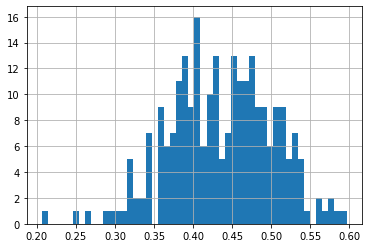

In [78]:
indonesia_fortifiable.hist(bins=50)

<AxesSubplot:>

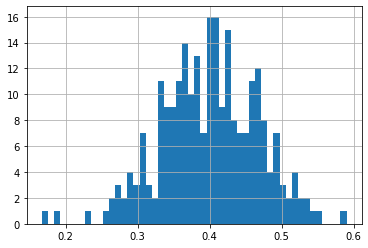

In [79]:
indonesia_fortified.hist(bins=50)

<AxesSubplot:>

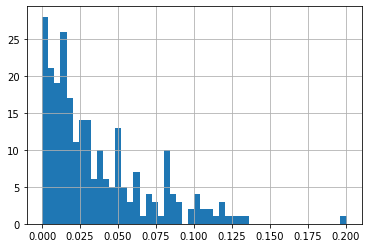

In [81]:
(indonesia_fortifiable - indonesia_fortified).hist(bins=50)

In [82]:
(indonesia_fortifiable - indonesia_fortified).describe()

count    250.000000
mean       0.035946
std        0.033834
min        0.000025
25%        0.011197
50%        0.025533
75%        0.051099
max        0.200631
dtype: float64